In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from processing import get_data

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split as TTS

import statsmodels.regression as smr

from collections import Counter

import tensorflow as tf
from tensorflow import feature_column
from tensorflow.keras import layers, losses
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [2]:
# get cleaned data
data = get_data()

In [3]:
data.head(2)

,name,released_at,mana_cost,cmc,type_line,oracle_text,power,toughness,colors,color_identity,keywords,set,rarity,flavor_text
0,Fury Sliver,2006-10-06,{5}{R},6.0,Creature — Sliver,All Sliver creatures have double strike.,3,3,['R'],['R'],[],tsp,uncommon,"""A rift opened, and our arrows were abruptly s..."
1,Kor Outfitter,2009-10-02,{W}{W},2.0,Creature — Kor Soldier,"When Kor Outfitter enters the battlefield, you...",2,2,['W'],['W'],[],zen,common,"""We take only what we need to survive. Believe..."


In [4]:
unsets = ['und', 'ust', 'unh', 'ugl']
indices = []

In [5]:
for abb in unsets:
    indices.append(data[data['set'] == abb].index)

In [6]:
for unset in indices:
    data.drop(index = unset, inplace = True)

In [7]:
data.reset_index(drop = True, inplace = True)

In [8]:
X_training, X_testing = TTS(data)
X_training, X_validating = TTS(X_training)

In [9]:
target = data['cmc'].astype(int)

In [10]:
# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop('cmc')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  return ds

In [11]:
experiment_training = df_to_dataset(X_training)
experiment_testing = df_to_dataset(X_testing)
experiment_validating = df_to_dataset(X_validating)

In [12]:
train_list = []
for row in X_training.itertuples(index = False):
    string = ''
    for term in row:
        string += f' {term}'
    train_list.append(string)    

In [13]:
test_list = []
for row in X_testing.itertuples(index = False):
    string = ''
    for term in row:
        string += f' {term}'
    test_list.append(string)

In [14]:
val_list = []
for row in X_validating.itertuples(index = False):
    string = ''
    for term in row:
        string += f' {term}'
    val_list.append(string)

In [15]:
train_np = np.array(train_list).reshape(-1,1)
test_np = np.array(test_list).reshape(-1,1)
val_np = np.array(val_list).reshape(-1,1)

In [16]:
x_in = tf.cast(train_list, tf.string)
y_in = tf.cast(target.values[X_training.index], tf.float32)

In [17]:
x_val = tf.cast(val_list, tf.string)
y_val = tf.cast(target.values[X_validating.index], tf.float32)

In [18]:
# convert DataFrame to tf DataSet, splitting to create train test sets
tf_train_data = tf.data.Dataset.from_tensor_slices((x_in, y_in))
tf_val_data = tf.data.Dataset.from_tensor_slices((x_val,y_val))

In [19]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE,
    standardize = 'lower_and_strip_punctuation',
    output_mode = 'tf-idf',
    #output_sequence_length = 200
    )
encoder.adapt(tf_train_data.map(lambda x, y: x))

In [20]:
vocab = encoder.get_vocabulary()

In [21]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return encoder(text), label

In [22]:
mapped_train = tf_train_data.batch(32).map(vectorize_text)
mapped_val = tf_val_data.batch(32).map(vectorize_text)


In [23]:
# shuffle data for training and create batches of (text, label) pairs
train_ds = mapped_train.cache().prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = mapped_val.cache().prefetch(buffer_size = tf.data.AUTOTUNE)

In [24]:
# indicator_columns
# indicator_column_names = data.columns
# for col_name in indicator_column_names:
#   categorical_column = feature_column.categorical_column_with_vocabulary_list(
#       col_name, dataframe[col_name].unique())
#   indicator_column = feature_column.indicator_column(categorical_column)
#   feature_columns.append(indicator_column)

In [25]:
# embedding columns
# breed1 = feature_column.categorical_column_with_vocabulary_list(
#       'Breed1', dataframe.Breed1.unique())
# breed1_embedding = feature_column.embedding_column(breed1, dimension=8)
# feature_columns.append(breed1_embedding)

In [26]:
# crossed columns
# age_type_feature = feature_column.crossed_column([age_buckets, animal_type], hash_bucket_size=100)
# feature_columns.append(feature_column.indicator_column(age_type_feature))

In [27]:
feature_columns = []
for column in data.columns:
    if column == 'cmc':
        continue
    inner = feature_column.categorical_column_with_vocabulary_list(column, data[column].unique())
    feature_columns.append(feature_column.embedding_column(inner, dimension = int(len(data[column].unique())**.5)))

In [28]:
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

In [29]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(len(vocab)+250, 128,
                             input_shape=[None]),
#     encoder,
    tf.keras.layers.GRU(128, return_sequences=True),
    tf.keras.layers.GRU(128),
    tf.keras.layers.Dense(32, activation = 'softmax')
])

model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(),
             optimizer = tf.keras.optimizers.Adam(1e-4),
             metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 128)         160000    
_________________________________________________________________
gru (GRU)                    (None, None, 128)         99072     
_________________________________________________________________
gru_1 (GRU)                  (None, 128)               99072     
_________________________________________________________________
dense (Dense)                (None, 32)                4128      
Total params: 362,272
Trainable params: 362,272
Non-trainable params: 0
_________________________________________________________________


In [30]:
history = model.fit(train_ds, 
                    epochs = 100, 
                    verbose = 2,
                    validation_data = val_ds)

Epoch 1/100
977/977 - 910s - loss: 2.1289 - accuracy: 0.1989 - val_loss: 2.0184 - val_accuracy: 0.2003
Epoch 2/100
977/977 - 906s - loss: 2.0241 - accuracy: 0.2016 - val_loss: 2.0167 - val_accuracy: 0.2003
Epoch 3/100
977/977 - 905s - loss: 2.0229 - accuracy: 0.2027 - val_loss: 2.0157 - val_accuracy: 0.2000
Epoch 4/100
977/977 - 905s - loss: 2.0205 - accuracy: 0.2032 - val_loss: 2.0090 - val_accuracy: 0.1999
Epoch 5/100
977/977 - 903s - loss: 1.9563 - accuracy: 0.2433 - val_loss: 1.8689 - val_accuracy: 0.2782
Epoch 6/100
977/977 - 903s - loss: 1.8471 - accuracy: 0.2885 - val_loss: 1.8290 - val_accuracy: 0.2919
Epoch 7/100
977/977 - 925s - loss: 1.8239 - accuracy: 0.2946 - val_loss: 1.8168 - val_accuracy: 0.2964
Epoch 8/100
977/977 - 925s - loss: 1.8129 - accuracy: 0.2989 - val_loss: 1.8086 - val_accuracy: 0.2997
Epoch 9/100
977/977 - 923s - loss: 1.8049 - accuracy: 0.3038 - val_loss: 1.7995 - val_accuracy: 0.3044
Epoch 10/100
977/977 - 877s - loss: 1.7953 - accuracy: 0.3098 - val_loss:

In [31]:
file = open('data/history.csv', 'w')
file.write(str(history.history))
file.close()

In [34]:
history.history

{'loss': [2.128910541534424,
  2.0240776538848877,
  2.0229475498199463,
  2.0204591751098633,
  1.9563030004501343,
  1.8470770120620728,
  1.823891520500183,
  1.812909722328186,
  1.804916501045227,
  1.7952795028686523,
  1.783211588859558,
  1.7695257663726807,
  1.7525672912597656,
  1.7280669212341309,
  1.702354907989502,
  1.6699520349502563,
  1.6384539604187012,
  1.6066248416900635,
  1.5838068723678589,
  1.5690088272094727,
  1.550519347190857,
  1.5372772216796875,
  1.5242478847503662,
  1.5111465454101562,
  1.496944785118103,
  1.483751654624939,
  1.471705675125122,
  1.4601165056228638,
  1.44795823097229,
  1.435286283493042,
  1.4224687814712524,
  1.4096884727478027,
  1.3960256576538086,
  1.3821990489959717,
  1.3688592910766602,
  1.3563060760498047,
  1.3442429304122925,
  1.3330174684524536,
  1.322096824645996,
  1.312050461769104,
  1.3020037412643433,
  1.2927168607711792,
  1.2831826210021973,
  1.2741025686264038,
  1.2646355628967285,
  1.2554219961166

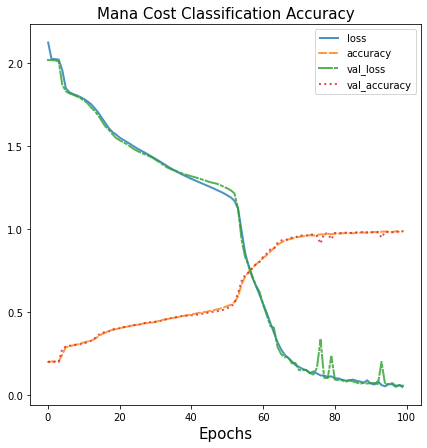

In [64]:
fig, ax = plt.subplots(figsize = (7,7))
styles = ['-','--', '-.',':']
d_join = ['miter', 'round', 'bevel', 'miter']
d_cap = ['butt', 'round', 'projecting', 'butt']
s_cap = ['butt', 'round', 'projecting', 'butt']
s_join = ['miter', 'round', 'bevel', 'miter']

for idx, key in enumerate(history.history.keys()):
    ax.plot(history.history[key], 
            label = key, 
            linestyle = styles[idx],
            linewidth = 2,
            alpha = .8,
            dash_joinstyle = d_join[idx],
            dash_capstyle = d_cap[idx],
            solid_capstyle = s_cap[idx],
            solid_joinstyle = s_join[idx]
           )

ax.set_xlabel('Epochs', fontsize = 15)
ax.set_title('Mana Cost Classification Accuracy', fontsize = 15)
ax.legend()

In [31]:
model = tf.keras.Sequential([
   # feature_layer,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        embeddings_regularizer = tf.keras.regularizers.l1_l2()

        ),
    #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32)
])

model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              optimizer = tf.keras.optimizers.Adam(1e-4),
              metrics = tf.metrics.SparseCategoricalAccuracy(),
              run_eagerly = True)


epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

model.summary()


Epoch 1/10


ValueError: Shape mismatch: The shape of labels (received (32, 1)) should equal the shape of logits except for the last dimension (received (32, 1000, 32)).

In [ ]:
model = tf.keras.Sequential([
    #feature_layer,
    layers.Embedding(len(encoder.get_vocabulary()), 16),
    layers.Dropout(0.2),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.2),
    layers.Dense(1)])

model.compile(loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.Adam(1e-4),
              metrics = tf.metrics.CategoricalAccuracy())

epochs = 10
history = model.fit(
    experiment_training,
    validation_data=experiment_testing,
    epochs=epochs)

model.summary()


In [ ]:
model = tf.keras.Sequential([
  feature_layer,
  layers.Dense(128, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dropout(.1),
  layers.Dense(1)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(experiment_training,
          validation_data=experiment_validating,
          epochs=10)